# 第8章: ニューラルネット

>第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainer(Pytorchに吸収)などの機械学習プラットフォームを活用せよ．

# 70. 単語ベクトルの和による特徴量

>問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xi
の特徴ベクトルxi
を並べた行列X
と正解ラベルを並べた行列（ベクトル）Y
を作成したい．(問題以下略)

まずは、指定のデータをダウンロード後、データフレームとして読込みます。そして、学習データ、検証データ、評価データに分割し、保存します。

In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-01-20 05:30:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  34.8MB/s    in 0.8s    

2023-01-20 05:30:05 (34.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


続いて、第7章の問題60でも利用した学習済み単語ベクトルをダウンロードし、ロードします。

In [4]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [5]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)
 
# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

最後に、特徴ベクトルとラベルベクトルを作成し、保存します。 なお、このあとPyTorchによるニューラルネットのインプットとして利用するため、Tensor型に変換しています。

【解説】Tensor型
Pytorchの用意した特殊な型。Numpyのndarrayと似ている。GPUで扱えるのが特徴。

In [6]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [7]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [8]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [9]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

# 71. 単層ニューラルネットワークによる予測

>問題省略

【解説】softmax関数

複数の出力値の合計が1となる関数

はじめに、SLPNetという単層ニューラルネットワークを定義します。__init__でネットワークを構成するレイヤーを定義し、forwardメソッドでインプットデータが順伝播時に通るレイヤーを順に配置していきます。

In [10]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

続いて、定義したモデルを初期化し、指示された計算を実行します。

In [11]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1) #最後の次元に対してsoftmaxを適用する。(今回は1×4だから最後の次元は4だね。.shape使ってみると分かる。)
print(y_hat_1) #未学習の行列Wでx1を分類したときに各カテゴリに属する確率

tensor([[0.2278, 0.0412, 0.1125, 0.6184]], grad_fn=<SoftmaxBackward0>)


In [12]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat) #x1～x4を分類したときに各カテゴリに属する確率

tensor([[0.2278, 0.0412, 0.1125, 0.6184],
        [0.7789, 0.0155, 0.1391, 0.0666],
        [0.5235, 0.0332, 0.2508, 0.1925],
        [0.4518, 0.1286, 0.2686, 0.1510]], grad_fn=<SoftmaxBackward0>)


# 72. 損失と勾配の計算

>学習データの事例 x1 と事例集合 x1 , x2 , x3 , x4 に対して，クロスエントロピー損失と，行列 W に対する勾配を計算せよ．なお，ある事例 xi に対して損失は次式で計算される．(問題省略)

【解説】

>入力ベクトルの要素毎に出力に対する偏微分を計算し、それらを並べてベクトルにしたものが勾配 (gradient) 

>クロスエントロピー : 確率分布pと確率分布qの近似性を表現する関数

ここでは、nnパッケージのCrossEntropyLossを利用します。 モデルの出力ベクトルとラベルベクトルを入力することで、上式の平均損失を計算することができます

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 損失を計算。入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.4791
勾配:
tensor([[-0.0646, -0.0044, -0.0053,  ..., -0.0580, -0.0334,  0.0670],
        [ 0.0034,  0.0002,  0.0003,  ...,  0.0031,  0.0018, -0.0036],
        [ 0.0094,  0.0006,  0.0008,  ...,  0.0085,  0.0049, -0.0098],
        [ 0.0517,  0.0035,  0.0042,  ...,  0.0465,  0.0268, -0.0537]])


In [15]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.1522
勾配:
tensor([[-9.5812e-03,  7.6070e-03, -2.2958e-02,  ..., -4.1919e-02,
          2.6017e-03,  2.4102e-02],
        [-7.1375e-03, -5.0141e-03,  2.4728e-02,  ...,  2.5740e-02,
          1.4758e-02,  1.4373e-03],
        [ 1.7070e-02, -8.9820e-03, -1.9326e-02,  ..., -1.6709e-03,
          9.5381e-05,  6.5056e-03],
        [-3.5151e-04,  6.3891e-03,  1.7555e-02,  ...,  1.7850e-02,
         -1.7455e-02, -3.2045e-02]])


# 73. 確率的勾配降下法による学習

>確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

【解説】確率的勾配降下法
>勾配法という最適化手法において必要な勾配の計算を、確率を使うことで高速に行う方法

学習に当たり、DatasetとDataloaderを準備します。 **Datasetは特徴ベクトルとラベルベクトルを合わせて保持することができる型**で、以下のクラスを用いてもとのTensorを変換します。

In [16]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

変換後、DataLoaderを作成します。**DataloaderはDatasetを入力とし、指定したサイズ(batch_size)にまとめたデータを順に取り出すことができます。**ここではbatch_size=1としているので、1つずつデータを取り出すDataloaderを作成することを意味します。 なお、Dataloaderはfor文で順に取り出すか、またはnext(iter(Dataloader))で次のかたまりを呼び出すことが可能です。

In [17]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

データの準備ができたので、行列W
を学習します。 モデルの定義、損失関数の定義は前問と同様です。今回は計算した勾配から重みも更新するため、オプティマイザも定義します。ここでは指示に従いSGDをセットしています。

【解説】オプティマイザ

>対象の設定や構造などを調整し、より好ましい状態に組み替える「最適化」（optimization）を行うためのソフトウェアや機能のこと。

部品が揃ったところで、エポック数を10として学習を実行します。

In [18]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播(解説後述) + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()
 
  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4728, loss_valid: 0.3628
epoch: 2, loss_train: 0.3099, loss_valid: 0.3308
epoch: 3, loss_train: 0.2810, loss_valid: 0.3164
epoch: 4, loss_train: 0.2651, loss_valid: 0.3066
epoch: 5, loss_train: 0.2555, loss_valid: 0.3058
epoch: 6, loss_train: 0.2490, loss_valid: 0.3054
epoch: 7, loss_train: 0.2432, loss_valid: 0.3078
epoch: 8, loss_train: 0.2389, loss_valid: 0.3030
epoch: 9, loss_train: 0.2354, loss_valid: 0.3047
epoch: 10, loss_train: 0.2324, loss_valid: 0.3086


【解説】誤差逆伝播法
>1度出力層まで計算を行い、各ノードの結果と重みを使って、後方（右側）から先頭（左側）に向かって微分を行う方法。単純にニューラルネットワークを何度も微分するより少ない時間で計算できる。

エポックが進むについて、徐々に学習データの損失が下がっていることが分かります。

# 74. 正解率の計測

>問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

学習したモデルとDataloaderを入力として、正解率を算出する関数を定義します。

In [19]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [20]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.924
正解率（評価データ）：0.903


# 75. 損失と正解率のプロット

>問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

前問の関数を損失も計算できるように改変し、エポック毎に適用することで損失と正解率を記録します。

In [21]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

In [22]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

epoch: 1, loss_train: 0.3321, accuracy_train: 0.8854, loss_valid: 0.3665, accuracy_valid: 0.8705
epoch: 2, loss_train: 0.2898, accuracy_train: 0.9028, loss_valid: 0.3324, accuracy_valid: 0.8877
epoch: 3, loss_train: 0.2649, accuracy_train: 0.9115, loss_valid: 0.3170, accuracy_valid: 0.8952
epoch: 4, loss_train: 0.2556, accuracy_train: 0.9148, loss_valid: 0.3130, accuracy_valid: 0.8967
epoch: 5, loss_train: 0.2465, accuracy_train: 0.9177, loss_valid: 0.3085, accuracy_valid: 0.8997
epoch: 6, loss_train: 0.2408, accuracy_train: 0.9167, loss_valid: 0.3053, accuracy_valid: 0.8990
epoch: 7, loss_train: 0.2346, accuracy_train: 0.9192, loss_valid: 0.3070, accuracy_valid: 0.8975
epoch: 8, loss_train: 0.2336, accuracy_train: 0.9209, loss_valid: 0.3091, accuracy_valid: 0.8967
epoch: 9, loss_train: 0.2274, accuracy_train: 0.9235, loss_valid: 0.3030, accuracy_valid: 0.8990
epoch: 10, loss_train: 0.2245, accuracy_train: 0.9244, loss_valid: 0.3032, accuracy_valid: 0.8975
epoch: 11, loss_train: 0.2234

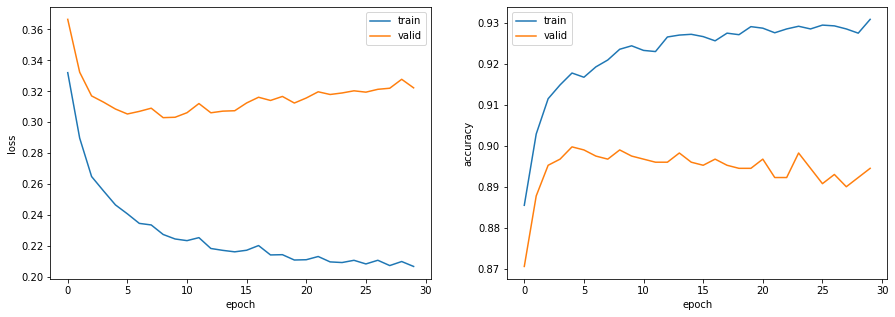

In [23]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 76. チェックポイント

>問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

学習途中のパラメータはmodel.state_dict()、最適化アルゴリズムの内部状態はoptimizer.state_dict()でアクセス可能なので、各エポックでエポック数と合わせて保存する処理を追加します。 なお、出力は前問と同様のため省略します。

In [24]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

epoch: 1, loss_train: 0.3295, accuracy_train: 0.8852, loss_valid: 0.3584, accuracy_valid: 0.8772
epoch: 2, loss_train: 0.2880, accuracy_train: 0.8987, loss_valid: 0.3270, accuracy_valid: 0.8832
epoch: 3, loss_train: 0.2658, accuracy_train: 0.9115, loss_valid: 0.3112, accuracy_valid: 0.8952
epoch: 4, loss_train: 0.2556, accuracy_train: 0.9106, loss_valid: 0.3100, accuracy_valid: 0.8915
epoch: 5, loss_train: 0.2448, accuracy_train: 0.9185, loss_valid: 0.3058, accuracy_valid: 0.8952
epoch: 6, loss_train: 0.2384, accuracy_train: 0.9192, loss_valid: 0.3005, accuracy_valid: 0.8967
epoch: 7, loss_train: 0.2338, accuracy_train: 0.9204, loss_valid: 0.3020, accuracy_valid: 0.8952
epoch: 8, loss_train: 0.2297, accuracy_train: 0.9218, loss_valid: 0.3029, accuracy_valid: 0.8975
epoch: 9, loss_train: 0.2269, accuracy_train: 0.9239, loss_valid: 0.3028, accuracy_valid: 0.8960
epoch: 10, loss_train: 0.2242, accuracy_train: 0.9232, loss_valid: 0.3030, accuracy_valid: 0.8937


# 77. ミニバッチ化

>問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

【解説】バッチサイズ
>勾配降下法では、学習するデータセットをいくつかのグループ（バッチと言います）に分けることが一般的。バッチサイズとは、このときに分けられた各グループの大きさのことを指す。

バッチサイズを変えるごとにすべての処理を書くのは大変なので、Dataloaderの作成以降の処理をtrain_modelとして関数化し、バッチサイズを含むいくつかのパラメータを引数として設定します。

In [25]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

バッチサイズを変えながら、処理時間を計測します。

In [27]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3295, accuracy_train: 0.8898, loss_valid: 0.3594, accuracy_valid: 0.8713, 4.5799sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2978, accuracy_train: 0.8999, loss_valid: 0.3365, accuracy_valid: 0.8870, 2.1375sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2891, accuracy_train: 0.9025, loss_valid: 0.3316, accuracy_valid: 0.8870, 1.1182sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2847, accuracy_train: 0.9042, loss_valid: 0.3276, accuracy_valid: 0.8900, 0.6308sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2834, accuracy_train: 0.9052, loss_valid: 0.3273, accuracy_valid: 0.8870, 0.3583sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2823, accuracy_train: 0.9054, loss_valid: 0.3260, accuracy_valid: 0.8907, 0.2388sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2818, accuracy_train: 0.9054, loss_valid: 0.3258, accuracy_valid: 0.8915, 0.1836sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2829, accuracy_train: 0.9054, loss_valid: 0.3257, accuracy_valid: 0.8915, 0.1486sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2813, accuracy_

# 78. GPU上での学習

>問題77のコードを改変し，GPU上で学習を実行せよ．

GPUを指定する引数deviceをcalculate_loss_and_accuracy、train_modelに追加します。 それぞれの関数内で、モデルおよび入力TensorをGPUに送る処理を追加し、deviceにcudaを指定すればGPUを使用することができます。

なお、Google Colaboratoryでは、あらかじめ画面上部のメニューから、「ランタイム」、「ランタイムのタイプを変更」と進み、「ハードウェアアクセラレータ」を「GPU」に変更しておく必要があります（※ 利用しているプランによっては料金がかかります。事前にご確認ください）。

In [28]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [31]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3326, accuracy_train: 0.8880, loss_valid: 0.3470, accuracy_valid: 0.8832, 12.2926sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3326, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 5.0105sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3326, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 2.6149sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3325, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 1.3288sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3325, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 0.7324sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3325, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 0.4166sec
バッチサイズ: 64
epoch: 1, loss_train: 0.3326, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 0.2681sec
バッチサイズ: 128
epoch: 1, loss_train: 0.3326, accuracy_train: 0.8882, loss_valid: 0.3470, accuracy_valid: 0.8832, 0.1939sec
バッチサイズ: 256
epoch: 1, loss_train: 0.3320, accuracy

# 79. 多層ニューラルネットワーク

>問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

多層ニューラルネットワークMLPNetを新たに定義します。このネットワークは入力層 -> 中間層 -> 出力層の構成とし、中間層のあとにバッチノーマライゼーションを行うことにします。 また、train_modelでは新たに学習の打ち切り基準を導入します。今回はシンプルに、検証データの損失が3エポック連続で低下しなかった場合に打ち切るルールとします。 さらに、学習率を徐々に下げるスケジューラも追加し、汎化性能の向上を狙います。

【解説】バッチノーマライゼーション
>バッチノーマライゼーションとは、ミニバッチの同じチャンネル毎に、平均０分散1になるよう正規化を行います。 結果、出力が適度に分散され、勾配消失などの問題が起こりにくくなり、学習が適切に進みます。 

In [29]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))
 
    return x

In [30]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [32]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 1.0264, accuracy_train: 0.7332, loss_valid: 1.0239, accuracy_valid: 0.7350, 0.4660sec
epoch: 2, loss_train: 0.7775, accuracy_train: 0.7603, loss_valid: 0.7757, accuracy_valid: 0.7665, 0.4372sec
epoch: 3, loss_train: 0.6888, accuracy_train: 0.7700, loss_valid: 0.6892, accuracy_valid: 0.7732, 0.4393sec
epoch: 4, loss_train: 0.6410, accuracy_train: 0.7754, loss_valid: 0.6436, accuracy_valid: 0.7762, 0.4424sec
epoch: 5, loss_train: 0.6118, accuracy_train: 0.7781, loss_valid: 0.6160, accuracy_valid: 0.7777, 0.4358sec
epoch: 6, loss_train: 0.5849, accuracy_train: 0.7826, loss_valid: 0.5902, accuracy_valid: 0.7799, 0.4570sec
epoch: 7, loss_train: 0.5529, accuracy_train: 0.7936, loss_valid: 0.5596, accuracy_valid: 0.7927, 0.4408sec
epoch: 8, loss_train: 0.5243, accuracy_train: 0.8098, loss_valid: 0.5326, accuracy_valid: 0.8016, 0.4507sec
epoch: 9, loss_train: 0.5006, accuracy_train: 0.8222, loss_valid: 0.5104, accuracy_valid: 0.8166, 0.4488sec
epoch: 10, loss_train: 0.477

97エポックで打ち切りとなりました。 エポックごとの損失と正解率を可視化します。

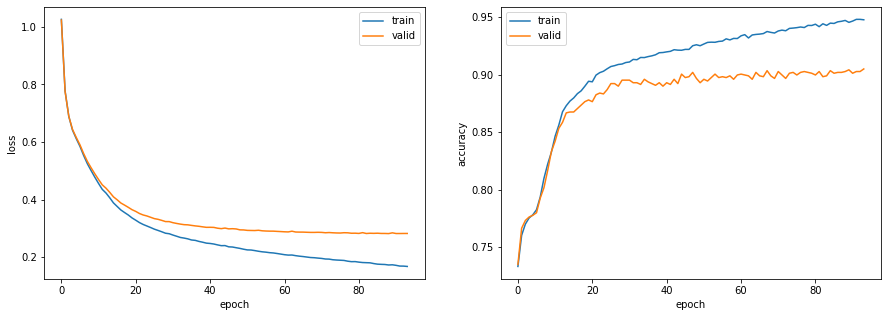

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

評価データの正解率を確認します。

In [34]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [35]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.948
正解率（評価データ）：0.909


単層ニューラルネットワークでは評価データの正解率が0.891でしたが、多層にすることによって3ポイント向上しています。